## インストール

In [ ]:
# pip install pingouin
# pip install plotnine
# pip install mysql-connector-python
# pip install numexpr
# pip install python-dotenv
# pip install japanize-matplotlib




In [ ]:
pip install xlwt


In [ ]:
from itertools import combinations

import csv
import MySQLdb
import mysql.connector as mydb
import pandas as pd
import pandas.io.sql as psql
import numpy as np
from pingouin import kruskal, mwu, multicomp
from plotnine import *


In [ ]:
# %load_ext dotenv
# %dotenv

%reload_ext dotenv


In [ ]:
host = os.environ.get('HOST')
user = os.environ.get('USER_NAME')
password = os.environ.get('PASSWORD')
database = os.environ.get('DATABASE')
question_database = os.environ.get('QUESTION_UI_DATABASE')
DB_CONFIG = dict(host=host, user=user, password=password, database=database)
QUESTION_DB_CONFIG = dict(
    host=host, user=user, password=password, database=question_database)


def check_db_connection(db_config=QUESTION_DB_CONFIG):
  connection = mydb.connect(**db_config)
  connection.ping(reconnect=True)
  # 接続できているかどうか確認
  print(connection.is_connected())


check_db_connection(QUESTION_DB_CONFIG)


In [ ]:
UI_CONDITION = ("question", "perspective", "non")

THEME_CONDITION = ("tpp", "airPollution", "vietnamTrip")

TPP_UI_CONDITION = (
    "TPP_WITH_QUERYUI",
    "TPP_WITH_NONUI",
)
AIRPOLLUTION_UI_CONDITION = (
    "AIRPOLLUTION_WITH_QUERYUI",
    "AIRPOLLUTION_WITH_NONUI",
)
VIETNAMTRIP_UI_CONDITION = (
    "VIETNAMTRIP_WITH_QUERYUI",
    "VIETNAMTRIP_WITH_NONUI"
)


In [ ]:

def get_dataframe_from_db(sql, db_config):
  """
  db上のデータをデータフレームとして取得
  """
  conn = mydb.connect(**db_config)
  df_read = pd.read_sql(sql, conn)
  conn.close()
  return df_read


def convert_csv_to_array(csv_path):
  """
  csvファイルの中身を一次元配列へ変換
  """
  result_arr = []
  with open(csv_path) as f:
      reader = csv.reader(f)
      for row in reader:
        result_arr.append(str(row[0]))
  return result_arr


def convert_singleArray_to_dataframe(array, columnName):
  df = pd.DataFrame(array, columns=[columnName],)
  return df


In [ ]:
users = get_dataframe_from_db('select * from users;', DB_CONFIG)
res = users.query('taskId == "AIRPOLLUTION_WITH_QUERYUI"').crowdId.tolist()


## 分析対象とする実験協力者

- ウェブ検索タスクにて意見文章の提出まで行い，事後アンケートへの回答が完了しているワーカー
- タスク所要時間が外れ値ではないワーカー

In [865]:

# ウェブ検索タスクと事後アンケートへの回答の両方が完了しているワーカー
questionnaire_answered_crowdIds_csv_path = './data/questionnaire_answered_crowdId.csv'
questionnaire_answered_crowdIds = convert_csv_to_array(questionnaire_answered_crowdIds_csv_path)
questionnaire_answered_crowdIds_df = convert_singleArray_to_dataframe(
    questionnaire_answered_crowdIds, 'crowdId')
users_who_complete_webSearchTask_df = get_dataframe_from_db("select * from users where hasFinishedWebSearchTask", DB_CONFIG)
users_who_completed_all_task_df =  users_who_complete_webSearchTask_df[users_who_complete_webSearchTask_df['crowdId'].isin(questionnaire_answered_crowdIds)]

users_who_completed_all_task_df = users_who_completed_all_task_df[
    users_who_completed_all_task_df['taskId'].isin([
            "TPP_WITH_QUERYUI",
            "TPP_WITH_NONUI",
            "AIRPOLLUTION_WITH_QUERYUI",
            "AIRPOLLUTION_WITH_NONUI",
            "VIETNAMTRIP_WITH_QUERYUI",
            "VIETNAMTRIP_WITH_NONUI"
    ])]
all_task_done_user_crowdIds = users_who_completed_all_task_df['crowdId'].tolist()
print('this')
print(len(all_task_done_user_crowdIds))

all_task_done_user_crowdIds.remove('angari14')
all_task_done_user_crowdIds.remove('NGSK-0811')

TPP_UI_CONDITION = (
    "TPP_WITH_QUERYUI",
    "TPP_WITH_NONUI",
)
AIRPOLLUTION_UI_CONDITION = (
    "AIRPOLLUTION_WITH_QUERYUI",
    "AIRPOLLUTION_WITH_NONUI",
)
VIETNAMTRIP_UI_CONDITION = (
    "VIETNAMTRIP_WITH_QUERYUI",
    "VIETNAMTRIP_WITH_NONUI"
)


# タスク所要時間の外れ値処理
def get_dataframe_without_outlier(df, target_column):
    q1 = df[target_column].quantile(
        0.25)
    q3 = df[target_column].quantile(
        0.75)
    iqr = q3 - q1
    threshold_upper = q3 + 1.5 * iqr
    threshold_lower = q1 - 1.5 * iqr
    df["threshold_lower"] = threshold_lower
    df["threshold_upper"] = threshold_upper

    df_without_outlier = df[(df[target_column] < threshold_upper) & (
        df[target_column] > threshold_lower)]
    return df_without_outlier

users_task_time_sql = """
select
	users.crowdId, users.taskId, taskTime.restarted_at, taskTime.finished_at
from
	taskTime
inner join
	users on users.crowdId = taskTime.crowdId;
"""

task_time_df = get_dataframe_from_db(users_task_time_sql, DB_CONFIG)
task_time_with_users_done_all_task_df = task_time_df[task_time_df['crowdId'].isin(
    all_task_done_user_crowdIds)]

task_time_with_users_done_all_task_df["taskTimeDuration"] = (
    task_time_with_users_done_all_task_df["finished_at"]-task_time_with_users_done_all_task_df["restarted_at"]).map(lambda x: x.total_seconds())

# tpp
tpp_task_time_with_users_done_all_task_df = task_time_with_users_done_all_task_df[
    task_time_with_users_done_all_task_df['taskId'].isin(TPP_UI_CONDITION)]
tpp_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    tpp_task_time_with_users_done_all_task_df, 'taskTimeDuration'
)
tpp_valid_crowdIds = tpp_task_time_with_users_done_all_task_df.crowdId.tolist()

# 大気汚染
air_pollution_task_time_with_users_done_all_task_df = task_time_with_users_done_all_task_df[
    task_time_with_users_done_all_task_df['taskId'].isin(AIRPOLLUTION_UI_CONDITION)]
air_pollution_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    air_pollution_task_time_with_users_done_all_task_df, 'taskTimeDuration'
)
air_pollution_valid_crowdIds = air_pollution_task_time_with_users_done_all_task_df.crowdId.tolist()

# ベトナム旅行
vietnam_task_time_with_users_done_all_task_df = task_time_with_users_done_all_task_df[
    task_time_with_users_done_all_task_df['taskId'].isin(VIETNAMTRIP_UI_CONDITION)]
vietnam_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    vietnam_task_time_with_users_done_all_task_df, 'taskTimeDuration'
)
vietnam_valid_crowdIds = vietnam_task_time_with_users_done_all_task_df.crowdId.tolist()
valid_user_crowdIds = air_pollution_valid_crowdIds
valid_user_crowdIds.extend(vietnam_valid_crowdIds)
valid_user_crowdIds.extend(tpp_valid_crowdIds)
print(len(valid_user_crowdIds))
# valid_user_crowdIds.remove('angari14')
# valid_user_crowdIds.remove('NGSK-0811')
print(len(valid_user_crowdIds))

# print(len(valid_users_df)) # 264人

## 問いかけ群ワーカー
# ウェブ検索タスクと事後アンケートへの回答の両方が完了している問いかけ群ワーカー
questionnaire_answered_questionUI_crowdIds_csv_path = './data/questionnaire_answered_questionUI_crowdId.csv'
questionnaire_answered_questionUI_crowdIds = convert_csv_to_array(
    questionnaire_answered_questionUI_crowdIds_csv_path)
questionnaire_answered_questionUI_crowdIds_df = convert_singleArray_to_dataframe(
    questionnaire_answered_questionUI_crowdIds, 'crowdId')
q_users_df = get_dataframe_from_db(
    "select * from users where hasFinishedWebSearchTask;", QUESTION_DB_CONFIG)
q_users_who_completed_all_task_df = q_users_df[q_users_df['crowdId'].isin(
    questionnaire_answered_questionUI_crowdIds)]
q_all_task_done_user_crowdIds = q_users_who_completed_all_task_df['crowdId'].tolist()
print('this')
print(len(q_all_task_done_user_crowdIds))
q_all_task_done_user_crowdIds.remove('masa_sap_jp')


q_users_task_time_sql = """
select
	users.crowdId, users.taskId, taskTime.restarted_at, taskTime.finished_at
from
	taskTime
inner join
	users on users.crowdId = taskTime.crowdId;
"""

q_task_time_df = get_dataframe_from_db(
    q_users_task_time_sql, QUESTION_DB_CONFIG)
q_task_time_with_users_done_all_task_df = q_task_time_df[q_task_time_df['crowdId'].isin(
    q_all_task_done_user_crowdIds)]
q_task_time_with_users_done_all_task_df["taskTimeDuration"] = (
    q_task_time_with_users_done_all_task_df["finished_at"]-q_task_time_with_users_done_all_task_df["restarted_at"]).map(lambda x: x.total_seconds())

# tpp
q_tpp_task_time_with_users_done_all_task_df = q_task_time_with_users_done_all_task_df[
    q_task_time_with_users_done_all_task_df[
        'taskId'
    ].isin(['TPP_WITH_QUESTIONUI'])]
q_tpp_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    q_tpp_task_time_with_users_done_all_task_df, 'taskTimeDuration')
q_tpp_crowdIds = q_tpp_task_time_with_users_done_all_task_df.crowdId.tolist()

# 大気汚染
q_air_pollution_task_time_with_users_done_all_task_df = q_task_time_with_users_done_all_task_df[
    q_task_time_with_users_done_all_task_df[
        'taskId'
    ].isin(['AIRPOLLUTION_WITH_QUESTIONUI'])]
q_air_pollution_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    q_air_pollution_task_time_with_users_done_all_task_df, 'taskTimeDuration')
q_air_pollution_valid_crowdIds = q_air_pollution_task_time_with_users_done_all_task_df.crowdId.tolist()
# ベトナム旅行
q_vietnam_task_time_with_users_done_all_task_df = q_task_time_with_users_done_all_task_df[
    q_task_time_with_users_done_all_task_df[
        'taskId'
    ].isin(['VIETNAMTRIP_WITH_QUESTIONUI'])]
q_vietnam_task_time_with_users_done_all_task_df = get_dataframe_without_outlier(
    q_vietnam_task_time_with_users_done_all_task_df, 'taskTimeDuration')
q_vietnam_valid_crowdIds = q_vietnam_task_time_with_users_done_all_task_df.crowdId.tolist()
q_valid_user_crowdIds = q_air_pollution_valid_crowdIds
q_valid_user_crowdIds.extend(q_vietnam_valid_crowdIds)
q_valid_user_crowdIds.extend(q_tpp_crowdIds)
# q_valid_user_crowdIds.remove('masa_sap_jp')
print(len(q_valid_user_crowdIds))






this
198
184
184
this
92
87


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

## 実験協力者の内訳

- questionUI群に関しては，別データで分析を行うため，perspectiveUI，nonUIのみ集計する

In [866]:
THEME_UI_CONDITION = (
                        "TPP_WITH_QUERYUI",
                        "AIRPOLLUTION_WITH_QUERYUI",
                        "VIETNAMTRIP_WITH_QUERYUI",
                        "TPP_WITH_NONUI",
                        "AIRPOLLUTION_WITH_NONUI",
                        "VIETNAMTRIP_WITH_NONUI"
                        )

users_df = get_dataframe_from_db('select * from users;', DB_CONFIG)
users_df = users_df[users_df['crowdId'].isin(
    valid_user_crowdIds)]

for theme_ui_condition in THEME_UI_CONDITION:
    res = users_df.query('taskId == @theme_ui_condition')
    print(theme_ui_condition)
    print(len(res))

# 問いかけ群ワーカー
QUESTION_UI_CONDITION = (
    "TPP_WITH_QUESTIONUI",
    "AIRPOLLUTION_WITH_QUESTIONUI",
    "VIETNAMTRIP_WITH_QUESTIONUI"
)

q_users_df = get_dataframe_from_db("select * from users;", QUESTION_DB_CONFIG)
q_users_df = q_users_df[q_users_df['crowdId'].isin(q_valid_user_crowdIds)]



for condition in QUESTION_UI_CONDITION:
    print(condition)
    res = q_users_df.query('taskId == @condition')
    print(len(res))

question_UI_participant = [28, 32, 28]
perspective_UI_participant = [32, 31, 23]
non_UI_participant = [33, 36, 30]

participant_list = [
    question_UI_participant,
    perspective_UI_participant,
    non_UI_participant
]

participant_df = pd.DataFrame(participant_list)
participant_df.index = ['questionUI','perspectiveUI', 'nonUI']
participant_df.columns = ['TPP', '大気汚染', 'ベトナム旅行']
participant_df.head()





TPP_WITH_QUERYUI
32
AIRPOLLUTION_WITH_QUERYUI
30
VIETNAMTRIP_WITH_QUERYUI
23
TPP_WITH_NONUI
33
AIRPOLLUTION_WITH_NONUI
36
VIETNAMTRIP_WITH_NONUI
30
TPP_WITH_QUESTIONUI
28
AIRPOLLUTION_WITH_QUESTIONUI
32
VIETNAMTRIP_WITH_QUESTIONUI
27


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,TPP,大気汚染,ベトナム旅行
questionUI,28,32,28
perspectiveUI,32,31,23
nonUI,33,36,30


In [867]:

# valid_user_crowdIds
# q_valid_user_crowdIds

def get_dataframe_without_invalid_user(df, valid_crowdIds):
  return df[df['crowdId'].isin(valid_crowdIds)]


## 意見文章の抽出

In [868]:
q_users_who_completed_all_task_df

# 大気汚染またはベトナム旅行がテーマだったワーカー
q_users_with_airPollution_or_vietnam_df = q_users_df[q_users_df['taskId'].isin(['AIRPOLLUTION_WITH_QUESTIONUI','VIETNAMTRIP_WITH_QUESTIONUI'])]
# 大気汚染またはベトナム旅行がテーマだったワーカーのcrowdId
q_crowdIds_with_airPollution_or_vietnam = q_users_with_airPollution_or_vietnam_df.crowdId.tolist()


q_opinion_document_df = get_dataframe_from_db('select * from opinionDocuments;', QUESTION_DB_CONFIG)
q_opinion_document_without_invalid_users = get_dataframe_without_invalid_user(
    q_opinion_document_df, q_crowdIds_with_airPollution_or_vietnam)
q_opinion_document_without_invalid_users.head()
q_opinion_document_without_invalid_users.to_csv('data/test.csv')
# q_opinion_document_list = q_opinion_document_without_invalid_users.content.tolist()

## 評価用シートの作成（csv化）
# csv_path = 'opinion.csv'

# with open(csv_path, "w", encoding="utf_8_sig") as f:
#     writer = csv.writer(f, lineterminator='\n')
#     for i in q_opinion_document_list:
#         writer.writerow([i])

<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


## 集計結果

- 中央値
- 標準偏差

In [869]:

TPP_UI_CONDITION = (
    "TPP_WITH_QUERYUI",
    "TPP_WITH_NONUI",
)

AIRPOLLUTION_UI_CONDITION = (
    "AIRPOLLUTION_WITH_QUERYUI",
    "AIRPOLLUTION_WITH_NONUI",
)

VIETNAMTRIP_UI_CONDITION = (
    "VIETNAMTRIP_WITH_QUERYUI",
    "VIETNAMTRIP_WITH_NONUI"
)

QUESTION_UI_CONDITION = (
    "AIRPOLLUTION_WITH_QUESTIONUI",
    "VIETNAMTRIP_WITH_QUESTIONUI"
)

def get_target_column_median_and_std(df, target_column, condition_list):
    for condition in condition_list:
        target_df = df.query('taskId == @condition')
        median_value = target_df[target_column].median()
        std_value = target_df[target_column].std()
        print('=======')
        print(condition)
        print('中央値', median_value, '標準偏差', std_value)

# タスク所要時間
task_time_sql = """
select
	tt.crowdId, tt.restarted_at, tt.finished_at, users.taskId
from
	taskTime as tt
inner join
	users on tt.crowdId = users.crowdId
"""
# 問いかけ群以外
task_time_df = get_dataframe_from_db(task_time_sql, DB_CONFIG)
task_time_df_without_invalid_user = get_dataframe_without_invalid_user(
    task_time_df, valid_user_crowdIds)
task_time_df_without_invalid_user["taskTimeDuration"] = (
    task_time_df_without_invalid_user["finished_at"]-task_time_df_without_invalid_user["restarted_at"]).map(lambda x: x.total_seconds())
task_time_df_without_invalid_user = get_dataframe_without_outlier(
    task_time_df_without_invalid_user, 'taskTimeDuration'
)
# 問いかけ群
q_task_time_df = get_dataframe_from_db(task_time_sql, QUESTION_DB_CONFIG)
q_task_time_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_task_time_df, q_valid_user_crowdIds)
q_task_time_df_without_invalid_user["taskTimeDuration"] = (
    q_task_time_df_without_invalid_user["finished_at"]-q_task_time_df_without_invalid_user["restarted_at"]).map(lambda x: x.total_seconds())
q_task_time_df_without_invalid_user = get_dataframe_without_outlier(
    q_task_time_df_without_invalid_user, 'taskTimeDuration'
)
# 大気汚染 && クエリ所要時間 && 問いかけ群以外
get_target_column_median_and_std(
    task_time_df_without_invalid_user, 'taskTimeDuration', AIRPOLLUTION_UI_CONDITION)
# ベトナム旅行 && クエリ所要時間 && 問いかけ群以外
get_target_column_median_and_std(
    task_time_df_without_invalid_user, 'taskTimeDuration', VIETNAMTRIP_UI_CONDITION)
# タスク所要時間 && 問いかけ群
get_target_column_median_and_std(
    q_task_time_df_without_invalid_user, 'taskTimeDuration', QUESTION_UI_CONDITION)


AIRPOLLUTION_WITH_QUERYUI
中央値 1092.0 標準偏差 599.285728377085
AIRPOLLUTION_WITH_NONUI
中央値 1002.0 標準偏差 727.9882934750532
VIETNAMTRIP_WITH_QUERYUI
中央値 938.0 標準偏差 576.4232531728912
VIETNAMTRIP_WITH_NONUI
中央値 1035.0 標準偏差 457.50628410984694
AIRPOLLUTION_WITH_QUESTIONUI
中央値 1239.0 標準偏差 740.8799013509588
VIETNAMTRIP_WITH_QUESTIONUI
中央値 1253.0 標準偏差 698.2679854376681


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-869-497c639dee28>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [870]:
# クエリ発行回数
query_count_sql = """
select
    users.crowdId, users.taskId, count(users.crowdId) as query_count
from
    queryLogs as ql
inner join
    users on ql.crowdId = users.crowdId
group by
    users.crowdId, users.taskId
"""

# 問いかけ群以外
query_count_df = get_dataframe_from_db(query_count_sql, DB_CONFIG)
query_count_df_without_invalid_user = get_dataframe_without_invalid_user(
    query_count_df, valid_user_crowdIds)
query_count_df_without_invalid_user = get_dataframe_without_outlier(
    query_count_df_without_invalid_user, 'query_count'
)
# 問いかけ群
q_query_count_df = get_dataframe_from_db(query_count_sql, QUESTION_DB_CONFIG)
q_query_count_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_query_count_df, q_valid_user_crowdIds)
q_query_count_df_without_invalid_user = get_dataframe_without_outlier(
    q_query_count_df_without_invalid_user, 'query_count')
# 大気汚染 && クエリ発行回数 && 問いかけ群以外
get_target_column_median_and_std(
    query_count_df_without_invalid_user, 'query_count', AIRPOLLUTION_UI_CONDITION)
# 大気汚染 && クエリ発行回数 && 問いかけ群以外
get_target_column_median_and_std(
    query_count_df_without_invalid_user, 'query_count', VIETNAMTRIP_UI_CONDITION)
# クエリ発行回数 && 問いかけ群
get_target_column_median_and_std(
    q_query_count_df_without_invalid_user, 'query_count', QUESTION_UI_CONDITION)


AIRPOLLUTION_WITH_QUERYUI
中央値 1.0 標準偏差 0.6405126152203485
AIRPOLLUTION_WITH_NONUI
中央値 1.0 標準偏差 0.674199862463242
VIETNAMTRIP_WITH_QUERYUI
中央値 1.0 標準偏差 0.5285941398709244
VIETNAMTRIP_WITH_NONUI
中央値 1.0 標準偏差 0.5773502691896258
AIRPOLLUTION_WITH_QUESTIONUI
中央値 1.0 標準偏差 1.0400044208570938
VIETNAMTRIP_WITH_QUESTIONUI
中央値 3.0 標準偏差 2.406340830072953


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) 

In [871]:

# 詳細ページ閲覧回数
visit_web_page_count_sql = """
select
	users.crowdId, users.taskId, count(users.crowdId) as visit_web_page_count
from
	visitPageLogs vl
inner join
	users on vl.crowdId = users.crowdId
group by
  users.crowdId, users.taskId;
"""

# 問いかけ群以外
visit_web_page_count_df = get_dataframe_from_db(visit_web_page_count_sql, DB_CONFIG)
visit_web_page_count_df_without_invalid_user = get_dataframe_without_invalid_user(
    visit_web_page_count_df, valid_user_crowdIds)
visit_web_page_count_df_without_invalid_user = get_dataframe_without_outlier(
    visit_web_page_count_df_without_invalid_user, 'visit_web_page_count'
)
# 問いかけ群
q_visit_web_page_count_df = get_dataframe_from_db(
    visit_web_page_count_sql, QUESTION_DB_CONFIG)
q_visit_web_page_count_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_visit_web_page_count_df, q_valid_user_crowdIds)
q_visit_web_page_count_df_without_invalid_user = get_dataframe_without_outlier(
    q_visit_web_page_count_df_without_invalid_user, 'visit_web_page_count'
)
# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    visit_web_page_count_df_without_invalid_user, 'visit_web_page_count', AIRPOLLUTION_UI_CONDITION)
# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    visit_web_page_count_df_without_invalid_user, 'visit_web_page_count', VIETNAMTRIP_UI_CONDITION)
# 詳細ページ閲覧時間 && 問いかけ群
get_target_column_median_and_std(
    q_visit_web_page_count_df_without_invalid_user, 'visit_web_page_count', QUESTION_UI_CONDITION)


AIRPOLLUTION_WITH_QUERYUI
中央値 4.0 標準偏差 2.1924111536540467
AIRPOLLUTION_WITH_NONUI
中央値 3.0 標準偏差 3.1462983883266853
VIETNAMTRIP_WITH_QUERYUI
中央値 5.0 標準偏差 2.645004240229123
VIETNAMTRIP_WITH_NONUI
中央値 3.0 標準偏差 2.7925725663734395
AIRPOLLUTION_WITH_QUESTIONUI
中央値 5.5 標準偏差 2.9445941860696054
VIETNAMTRIP_WITH_QUESTIONUI
中央値 7.0 標準偏差 3.691138839010767


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) 

In [872]:
# SERP閲覧時間
serp_time_duration_sql = """
select
	users.crowdId, users.taskId, st.time_on_serp
from
	serpTimeDuration as st
inner join
	users on st.crowdId = users.crowdId;
"""

# 問いかけ群以外
serp_time_duration_df = get_dataframe_from_db(
    serp_time_duration_sql, DB_CONFIG)
serp_time_duration_df_without_invalid_user = get_dataframe_without_invalid_user(
    serp_time_duration_df, valid_user_crowdIds)
serp_time_duration_df_without_invalid_user = get_dataframe_without_outlier(
    serp_time_duration_df_without_invalid_user, 'time_on_serp'
)
# 問いかけ群
q_serp_time_duration_df = get_dataframe_from_db(
    serp_time_duration_sql, QUESTION_DB_CONFIG)
q_serp_time_duration_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_serp_time_duration_df , q_valid_user_crowdIds)
q_serp_time_duration_df_without_invalid_user = get_dataframe_without_outlier(
    q_serp_time_duration_df_without_invalid_user, 'time_on_serp'
)

# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    serp_time_duration_df_without_invalid_user, 'time_on_serp', AIRPOLLUTION_UI_CONDITION)
# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    serp_time_duration_df_without_invalid_user, 'time_on_serp', VIETNAMTRIP_UI_CONDITION)
# 詳細ページ閲覧時間 && 問いかけ群
get_target_column_median_and_std(
    q_serp_time_duration_df_without_invalid_user, 'time_on_serp', QUESTION_UI_CONDITION)


AIRPOLLUTION_WITH_QUERYUI
中央値 729.0 標準偏差 306.76375921587277
AIRPOLLUTION_WITH_NONUI
中央値 646.0 標準偏差 336.66659746619115
VIETNAMTRIP_WITH_QUERYUI
中央値 564.0 標準偏差 331.15262433817526
VIETNAMTRIP_WITH_NONUI
中央値 570.5 標準偏差 345.8974667025828
AIRPOLLUTION_WITH_QUESTIONUI
中央値 733.0 標準偏差 314.38601130229074
VIETNAMTRIP_WITH_QUESTIONUI
中央値 758.5 標準偏差 289.27591566636755


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) 

In [873]:
# 最大クリック深度
max_ranking_sql = """
select
	vp.crowdId, max(ranking) as max_ranking, users.taskId
from
	visitPageLogs vp
inner join
	users on users.crowdId = vp.crowdId
group by
	crowdId, users.taskId;
"""

# 問いかけ群以外
max_ranking_df = get_dataframe_from_db(
    max_ranking_sql, DB_CONFIG)
max_ranking_df_without_invalid_user = get_dataframe_without_invalid_user(
    max_ranking_df, valid_user_crowdIds)
max_ranking_df_without_invalid_user = get_dataframe_without_outlier(
    max_ranking_df_without_invalid_user, 'max_ranking'
)
# 問いかけ群
q_max_ranking_df = get_dataframe_from_db(
    max_ranking_sql, QUESTION_DB_CONFIG)
q_max_ranking_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_max_ranking_df, q_valid_user_crowdIds)
q_max_ranking_df_without_invalid_user = get_dataframe_without_outlier(
    q_max_ranking_df_without_invalid_user, 'max_ranking'
)

# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    max_ranking_df_without_invalid_user, 'max_ranking', AIRPOLLUTION_UI_CONDITION)
# 大気汚染 && 詳細ページ閲覧時間 && 問いかけ群以外
get_target_column_median_and_std(
    max_ranking_df_without_invalid_user, 'max_ranking', VIETNAMTRIP_UI_CONDITION)
# 詳細ページ閲覧時間 && 問いかけ群
get_target_column_median_and_std(
    q_max_ranking_df_without_invalid_user, 'max_ranking', QUESTION_UI_CONDITION)



AIRPOLLUTION_WITH_QUERYUI
中央値 4.0 標準偏差 2.8094982883801634
AIRPOLLUTION_WITH_NONUI
中央値 4.0 標準偏差 4.437377894730756
VIETNAMTRIP_WITH_QUERYUI
中央値 5.0 標準偏差 3.789082059964241
VIETNAMTRIP_WITH_NONUI
中央値 4.0 標準偏差 2.5410908793553326
AIRPOLLUTION_WITH_QUESTIONUI
中央値 6.5 標準偏差 4.580265928833825
VIETNAMTRIP_WITH_QUESTIONUI
中央値 5.5 標準偏差 4.275167397547876


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) 

In [874]:
max_pagination_sql = """
select
	pl.crowdId, max(paginationCount) as max_pagination, users.taskId
from
	paginationLogs as pl
inner join
	users on users.crowdId = pl.crowdId
group by
	crowdId, users.taskId;
"""

# 問いかけ群以外
max_pagination_df = get_dataframe_from_db(
    max_pagination_sql, DB_CONFIG)
max_pagination_df_without_invalid_user = get_dataframe_without_invalid_user(
    max_pagination_df, valid_user_crowdIds)
max_pagination_df_without_invalid_user = get_dataframe_without_outlier(
    max_pagination_df_without_invalid_user, 'max_pagination'
)
# 問いかけ群
q_max_pagination_df = get_dataframe_from_db(
    max_pagination_sql, QUESTION_DB_CONFIG)
q_max_pagination_df_without_invalid_user = get_dataframe_without_invalid_user(
    q_max_pagination_df, q_valid_user_crowdIds)
q_max_pagination_df_without_invalid_user = get_dataframe_without_outlier(
    q_max_pagination_df_without_invalid_user, 'max_pagination'
)



<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-865-d55975ee1682>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-865-d55975ee1682>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) 

## 行動指標の分析
- クエリ発行回数
- タスク所要時間
- 詳細ページ閲覧時間
- SERP滞在時間
- 最大クリック深度

各トピックごとに，1要因（UI）で分散分析を行う．
水準は3つ
- questionUI
- perspectiveUI
- nonUI


In [875]:
TPP_CONDITION = (
    "TPP_WITH_QUESTIONUI",
    "TPP_WITH_QUESTIONUI",
    "TPP_WITH_QUESTIONUI",
)

AIRPOLLUTION_CONDITION = (
    "AIRPOLLUTION_WITH_QUESTIONUI",
    "AIRPOLLUTION_WITH_QUERYUI",
    "AIRPOLLUTION_WITH_NONUI",
)

VIETNAMTRIP_CONDITION = (
    "VIETNAMTRIP_WITH_QUESTIONUI",
    "VIETNAMTRIP_WITH_QUERYUI",
    "VIETNAMTRIP_WITH_NONUI"
)

# 多重比較
# 多重比較


def do_multiple_comparison_with_FDR_tpp(df, target_value, target_task=None):
    # 多重比較 with Benjamini-Hochberg法
    pvals = {}
    for ui_1, ui_2 in combinations(TPP_CONDITION, 2):
        if target_task:
            x = df[(df.task_type == target_task) & (
                df.taskId == ui_1)][target_value]
            y = df[(df.task_type == target_task) & (
                df.taskId == ui_2)][target_value]
        else:
            x = df[df.taskId == ui_1][target_value]
            y = df[df.taskId == ui_2][target_value]
        pval = float(mwu(x, y)['p-val'])
        pvals[(ui_1, ui_2)] = pval
    else:
        rejects, pvals_corrs = multicomp(list(pvals.values()), method='fdr_bh')
        result = {}
        for ui_pair, reject, pval_corr in zip(list(pvals.keys()), rejects, pvals_corrs):
            result[ui_pair] = (reject, pval_corr)
        return result
def do_multiple_comparison_with_FDR_airPollution(df, target_value, target_task=None):
    # 多重比較 with Benjamini-Hochberg法
    pvals = {}
    for ui_1, ui_2 in combinations(AIRPOLLUTION_CONDITION, 2):
        if target_task:
            x = df[(df.task_type == target_task) & (
                df.taskId == ui_1)][target_value]
            y = df[(df.task_type == target_task) & (
                df.taskId == ui_2)][target_value]
        else:
            x = df[df.taskId == ui_1][target_value]
            y = df[df.taskId == ui_2][target_value]
        pval = float(mwu(x, y)['p-val'])
        pvals[(ui_1, ui_2)] = pval
    else:
        rejects, pvals_corrs = multicomp(list(pvals.values()), method='fdr_bh')
        result = {}
        for ui_pair, reject, pval_corr in zip(list(pvals.keys()), rejects, pvals_corrs):
            result[ui_pair] = (reject, pval_corr)
        return result


def do_multiple_comparison_with_FDR_vietnam(df, target_value, target_task=None):
    # 多重比較 with Benjamini-Hochberg法
    pvals = {}
    for ui_1, ui_2 in combinations(VIETNAMTRIP_CONDITION, 2):
        if target_task:
            x = df[(df.task_type == target_task) & (
                df.taskId == ui_1)][target_value]
            y = df[(df.task_type == target_task) & (
                df.taskId == ui_2)][target_value]
        else:
            x = df[df.taskId == ui_1][target_value]
            y = df[df.taskId == ui_2][target_value]
        pval = float(mwu(x, y)['p-val'])
        pvals[(ui_1, ui_2)] = pval
    else:
        rejects, pvals_corrs = multicomp(list(pvals.values()), method='fdr_bh')
        result = {}
        for ui_pair, reject, pval_corr in zip(list(pvals.keys()), rejects, pvals_corrs):
            result[ui_pair] = (reject, pval_corr)
        return result


In [876]:

# tpp
tpp_task_time_df = task_time_df_without_invalid_user[
    task_time_df_without_invalid_user['taskId'].isin(TPP_UI_CONDITION)
]
q_tpp_task_time_df = q_task_time_df_without_invalid_user[
    q_task_time_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]
all_condition_tpp_task_time_df = pd.concat([
    tpp_task_time_df,
    q_tpp_task_time_df
])
# 大気汚染
airPollution_task_time_df = task_time_df_without_invalid_user[
    task_time_df_without_invalid_user['taskId'].isin(AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_task_time_df = q_task_time_df_without_invalid_user[
    q_task_time_df_without_invalid_user['taskId'].isin(['AIRPOLLUTION_WITH_QUESTIONUI'])
]

all_condition_airPollution_task_time_df = pd.concat([
    airPollution_task_time_df,
    q_airPollution_task_time_df
])


# ベトナム旅行
vietnam_task_time_df = task_time_df_without_invalid_user[task_time_df_without_invalid_user['taskId'].isin(
    VIETNAMTRIP_UI_CONDITION)]
q_vietnam_task_time_df = q_task_time_df_without_invalid_user[q_task_time_df_without_invalid_user['taskId'].isin(['VIETNAMTRIP_WITH_QUESTIONUI'])]
all_condition_vietnam_task_time_df = pd.concat(
    [vietnam_task_time_df, q_vietnam_task_time_df])


In [877]:

# tpp
tpp_query_count_df = query_count_df_without_invalid_user[
    query_count_df_without_invalid_user['taskId'].isin(
        TPP_UI_CONDITION)
]
q_tpp_query_count_df = q_query_count_df_without_invalid_user[
    q_query_count_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]

all_condition_tpp_query_count_df = pd.concat(
    [tpp_query_count_df, q_tpp_query_count_df])

# 大気汚染
airPollution_query_count_df = query_count_df_without_invalid_user[
    query_count_df_without_invalid_user['taskId'].isin(AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_query_count_df = q_query_count_df_without_invalid_user[
    q_query_count_df_without_invalid_user['taskId'].isin(['AIRPOLLUTION_WITH_QUESTIONUI'])
]
all_condition_airPollution_query_count_df = pd.concat(
    [airPollution_query_count_df, q_airPollution_query_count_df])


# ベトナム旅行
vietnam_query_count_df = query_count_df_without_invalid_user[
    query_count_df_without_invalid_user['taskId'].isin(VIETNAMTRIP_UI_CONDITION)
]
q_vietnam_query_count_df = q_query_count_df_without_invalid_user[
    q_query_count_df_without_invalid_user['taskId'].isin(['VIETNAMTRIP_WITH_QUESTIONUI'])
]
all_condition_vietnam_query_count_df = pd.concat([
    vietnam_query_count_df,
    q_vietnam_query_count_df
])



### 詳細ページ閲覧回数

In [878]:
# tpp
tpp_visit_web_page_count_df = visit_web_page_count_df_without_invalid_user[
    visit_web_page_count_df_without_invalid_user['taskId'].isin(
        TPP_UI_CONDITION)
]
q_tpp_visit_web_page_count_df = q_visit_web_page_count_df_without_invalid_user[
    q_visit_web_page_count_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]
all_condition_tpp_visit_web_page_count_df = pd.concat(
    [tpp_visit_web_page_count_df, q_tpp_visit_web_page_count_df])

# 大気汚染
airPollution_visit_web_page_count_df = visit_web_page_count_df_without_invalid_user[
    visit_web_page_count_df_without_invalid_user['taskId'].isin(
        AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_visit_web_page_count_df = q_visit_web_page_count_df_without_invalid_user[
    q_visit_web_page_count_df_without_invalid_user['taskId'].isin(
        ['AIRPOLLUTION_WITH_QUESTIONUI'])
]
all_condition_airPollution_visit_web_page_count_df = pd.concat(
    [airPollution_visit_web_page_count_df, q_airPollution_visit_web_page_count_df])


# ベトナム旅行
vietnam_visit_web_page_count_df = visit_web_page_count_df_without_invalid_user[
    visit_web_page_count_df_without_invalid_user['taskId'].isin(
        VIETNAMTRIP_UI_CONDITION)
]
q_vietnam_visit_web_page_count_df = q_visit_web_page_count_df_without_invalid_user[
    q_visit_web_page_count_df_without_invalid_user['taskId'].isin(
        ['VIETNAMTRIP_WITH_QUESTIONUI'])
]
all_condition_vietnam_visit_web_page_count_df = pd.concat([
    vietnam_visit_web_page_count_df,
    q_vietnam_visit_web_page_count_df
])





### SERP閲覧時間

In [879]:
# tpp
tpp_serp_time_duration_df = serp_time_duration_df_without_invalid_user[
    serp_time_duration_df_without_invalid_user['taskId'].isin(
        TPP_UI_CONDITION)
]
q_tpp_serp_time_duration_df = q_serp_time_duration_df_without_invalid_user[
    q_serp_time_duration_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]
all_condition_tpp_serp_time_duration_df = pd.concat(
    [tpp_serp_time_duration_df, q_tpp_serp_time_duration_df])

# 大気汚染
airPollution_serp_time_duration_df = serp_time_duration_df_without_invalid_user[
    serp_time_duration_df_without_invalid_user['taskId'].isin(
        AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_serp_time_duration_df = q_serp_time_duration_df_without_invalid_user[
    q_serp_time_duration_df_without_invalid_user['taskId'].isin(
        ['AIRPOLLUTION_WITH_QUESTIONUI'])
]
all_condition_airPollution_serp_time_duration_df = pd.concat(
    [airPollution_serp_time_duration_df, q_airPollution_serp_time_duration_df])


# ベトナム旅行
vietnam_serp_time_duration_df = serp_time_duration_df_without_invalid_user[
    serp_time_duration_df_without_invalid_user['taskId'].isin(
        VIETNAMTRIP_UI_CONDITION)
]
q_vietnam_serp_time_duration_df = q_serp_time_duration_df_without_invalid_user[
    q_serp_time_duration_df_without_invalid_user['taskId'].isin(
        ['VIETNAMTRIP_WITH_QUESTIONUI'])
]
all_condition_vietnam_serp_time_duration_df = pd.concat([
    vietnam_serp_time_duration_df,
    q_vietnam_serp_time_duration_df
])



### 最大クリック深度

In [880]:
# tpp
tpp_max_ranking_df = max_ranking_df_without_invalid_user[
    max_ranking_df_without_invalid_user['taskId'].isin(
        TPP_UI_CONDITION)
]
q_tpp_max_ranking_df = q_max_ranking_df_without_invalid_user[
    q_max_ranking_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]
all_condition_tpp_max_ranking_df = pd.concat(
    [tpp_max_ranking_df, q_tpp_max_ranking_df])

# 大気汚染
airPollution_max_ranking_df = max_ranking_df_without_invalid_user[
    max_ranking_df_without_invalid_user['taskId'].isin(
        AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_max_ranking_df = q_max_ranking_df_without_invalid_user[
    q_max_ranking_df_without_invalid_user['taskId'].isin(
        ['AIRPOLLUTION_WITH_QUESTIONUI'])
]
all_condition_airPollution_max_ranking_df = pd.concat(
    [airPollution_max_ranking_df, q_airPollution_max_ranking_df])

# ベトナム旅行
vietnam_max_ranking_df = max_ranking_df_without_invalid_user[
    max_ranking_df_without_invalid_user['taskId'].isin(
        VIETNAMTRIP_UI_CONDITION)
]
q_vietnam_max_ranking_df = q_max_ranking_df_without_invalid_user[
    q_max_ranking_df_without_invalid_user['taskId'].isin(
        ['VIETNAMTRIP_WITH_QUESTIONUI'])
]
all_condition_vietnam_max_ranking_df = pd.concat([
    vietnam_max_ranking_df,
    q_vietnam_max_ranking_df
])


### 最大ページネーション

In [881]:
# tpp
tpp_max_pagination_df = max_pagination_df_without_invalid_user[
    max_pagination_df_without_invalid_user['taskId'].isin(
        TPP_UI_CONDITION)
]
q_tpp_max_pagination_df = q_max_pagination_df_without_invalid_user[
    q_max_pagination_df_without_invalid_user['taskId'].isin(
        ['TPP_WITH_QUESTIONUI'])
]
all_condition_tpp_max_pagination_df = pd.concat(
    [tpp_max_pagination_df, q_tpp_max_pagination_df])

# 大気汚染
airPollution_max_pagination_df = max_pagination_df_without_invalid_user[
    max_pagination_df_without_invalid_user['taskId'].isin(
        AIRPOLLUTION_UI_CONDITION)
]
q_airPollution_max_pagination_df = q_max_pagination_df_without_invalid_user[
    q_max_pagination_df_without_invalid_user['taskId'].isin(
        ['AIRPOLLUTION_WITH_QUESTIONUI'])
]
all_condition_airPollution_max_pagination_df = pd.concat(
    [airPollution_max_pagination_df, q_airPollution_max_pagination_df])

# ベトナム旅行
vietnam_max_pagination_df = max_pagination_df_without_invalid_user[
    max_pagination_df_without_invalid_user['taskId'].isin(
        VIETNAMTRIP_UI_CONDITION)
]
q_vietnam_max_pagination_df = q_max_pagination_df_without_invalid_user[
    q_max_pagination_df_without_invalid_user['taskId'].isin(
        ['VIETNAMTRIP_WITH_QUESTIONUI'])
]
all_condition_vietnam_max_pagination_df = pd.concat([
    vietnam_max_pagination_df,
    q_vietnam_max_pagination_df
])


In [ ]:
tpp_df_list = [
    all_condition_tpp_task_time_df,
    all_condition_tpp_query_count_df,
    all_condition_tpp_visit_web_page_count_df,
    all_condition_tpp_serp_time_duration_df,
    all_condition_tpp_max_ranking_df,
    all_condition_tpp_max_pagination_df
]

air_pollution_df_list = [
    all_condition_airPollution_task_time_df,
    all_condition_airPollution_query_count_df,
    all_condition_airPollution_visit_web_page_count_df,
    all_condition_airPollution_serp_time_duration_df,
    all_condition_airPollution_max_ranking_df,
    all_condition_airPollution_max_pagination_df,
]
vietnam_df_list = [
    all_condition_vietnam_task_time_df,
    all_condition_vietnam_query_count_df,
    all_condition_vietnam_visit_web_page_count_df,
    all_condition_vietnam_serp_time_duration_df,
    all_condition_vietnam_max_ranking_df,
    all_condition_vietnam_max_pagination_df,
]




def recursive_merge(dfs):
  #最後のdfはdfを返すだけ
  if len(dfs) == 1:
    return dfs[0]

  #再起処理/popで一つだけ取り出し、残りを次の処理へ
  else:
    tmp = dfs.pop()

  return pd.merge(
      recursive_merge(dfs),
      tmp,
      how='outer',
  )

tpp_behavior_result_df = recursive_merge(tpp_df_list)
air_pollution_behavior_result_df = recursive_merge(air_pollution_df_list)
vietnam_behavior_result_df = recursive_merge(vietnam_df_list)

# 大気汚染
# vietnam_behavior_result_df.query(
#     'taskId == "VIETNAMTRIP_WITH_NONUI"').describe().round(2)
# air_pollution_behavior_result_df.std()

# ベトナム旅行
# vietnam_behavior_result_df.median()
# vietnam_behavior_result_df.std()

behavior_evaluation_items = (
    'taskTimeDuration',
    'query_count',
    'visit_web_page_count',
    'time_on_serp',
    'max_ranking',
    'max_pagination'
)

# tpp
# for evaluation_item in behavior_evaluation_items:
#     print(evaluation_item)
#     anova_result = kruskal(
#         data=tpp_behavior_result_df, dv=evaluation_item, between='taskId')
#     display(anova_result)
#     if int(anova_result['p-unc'] < 0.05):
#         mcomp_result = do_multiple_comparison_with_FDR_tpp(
#             tpp_behavior_result_df, target_value=evaluation_item)
#         display(mcomp_result)

# 大気汚染
for evaluation_item in behavior_evaluation_items:
    print(evaluation_item)
    anova_result = kruskal(
        data=air_pollution_behavior_result_df, dv=evaluation_item, between='taskId')
    display(anova_result.round(2))
    if int(anova_result['p-unc'] < 0.05):
        mcomp_result = do_multiple_comparison_with_FDR_airPollution(
            air_pollution_behavior_result_df, target_value=evaluation_item)
        display(mcomp_result)


# ベトナム旅行
for evaluation_item in behavior_evaluation_items:
    print(evaluation_item)
    anova_result = kruskal(
        data=vietnam_behavior_result_df, dv=evaluation_item, between='taskId')
    display(anova_result.round(2))
    if int(anova_result['p-unc'] < 0.05):
        mcomp_result = do_multiple_comparison_with_FDR_vietnam(
            vietnam_behavior_result_df, target_value=evaluation_item)
        display(mcomp_result)


## 正規分布確認

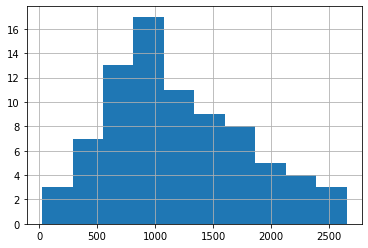

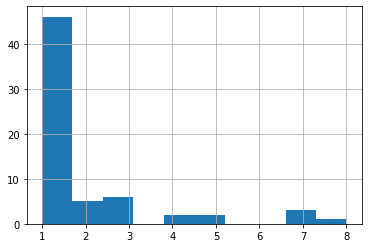

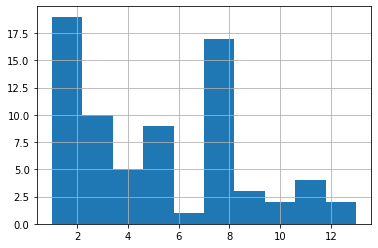

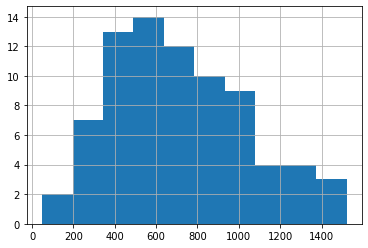

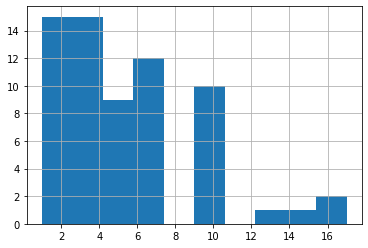

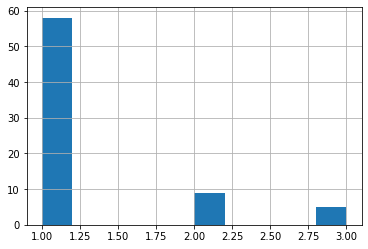

In [907]:
import scipy.stats as stats
import matplotlib.pyplot as plt

air_pollution_df_list = [
    all_condition_airPollution_task_time_df,
    all_condition_airPollution_query_count_df,
    all_condition_airPollution_visit_web_page_count_df,
    all_condition_airPollution_serp_time_duration_df,
    all_condition_airPollution_max_ranking_df,
    all_condition_airPollution_max_pagination_df,
]
vietnam_df_list = [
    all_condition_vietnam_task_time_df,
    all_condition_vietnam_query_count_df,
    all_condition_vietnam_visit_web_page_count_df,
    all_condition_vietnam_serp_time_duration_df,
    all_condition_vietnam_max_ranking_df,
    all_condition_vietnam_max_pagination_df,
]

behavior_evaluation_items = (
    'taskTimeDuration',
    'query_count',
    'visit_web_page_count',
    'time_on_serp',
    'max_ranking',
    'max_pagination'
)

# for i in range(6):
#   target_df = air_pollution_df_list[i]
#   evaluation_item = behavior_evaluation_items[i]
#   fig = plt.figure()
#   target_df[evaluation_item].hist()

for i in range(6):
  target_df = vietnam_df_list[i]
  evaluation_item = behavior_evaluation_items[i]
  fig = plt.figure()
  target_df[evaluation_item].hist()
  # print(evaluation_item)
  # res =stats.shapiro(target_df[evaluation_item])
  # print(res)



## 事後アンケート分析

In [884]:
questionnaire_tpp_question_ui_csv_path = './data/再実験_事後アンケート_問いかけボットUI_ベトナム旅行（回答）.csv'
questionnaire_air_pollution_question_ui_csv_path = './data/再実験_事後アンケート_問いかけボットUI_大気汚染（回答）.csv'
questionnaire_vietnam_question_ui_csv_path = './data/再実験_事後アンケート_問いかけボットUI_ベトナム旅行（回答）.csv'
questionnaire_perspective_ui_csv_path = './data/意見形成タスク事後アンケート_観点一覧UI.csv'
questionnaire_non_ui_csv_path = './data/意見形成タスク事後アンケート_NonUI.csv'

questionnaire_tpp_question_ui_df = pd.read_csv(
    questionnaire_tpp_question_ui_csv_path)
questionnaire_air_pollution_question_ui_df = pd.read_csv(questionnaire_air_pollution_question_ui_csv_path)
questionnaire_vietnam_question_ui_df = pd.read_csv(questionnaire_vietnam_question_ui_csv_path)
questionnaire_perspective_ui_df = pd.read_csv(questionnaire_perspective_ui_csv_path)
questionnaire_non_ui_df = pd.read_csv(questionnaire_non_ui_csv_path)

questionnaire_tpp_question_ui_df.head()

# カラム名の置換
replace_columns_dict_for_question_ui = {
    'あなたは，タスクで与えられたテーマについて，幅広い観点でウェブ検索を行うことができたと思いますか？': 'various_perspective_search',
    'あなたは，タスクで与えられたテーマについて，ウェブ検索を行った結果，理解をより深めることができましたか？': 'deepen_understanding_theme',
    'あなたは，問いかけ文の提示は，タスクで与えられたテーマに関するあなた自身の理解度を確認するのに役立ちましたか？': 'check_understanding',
    'あなたは，ウェブ検索中に定期的に提示される問いかけ文は，それを必要とするタイミングで提示されたと思いますか？' : 'is_question_suggesting_appropriately',
    'あなたは，タスク中に提示された問いかけ文は，日本語文章として自然でしたか？': 'is_question_natural',
    'あなたは，タスク中に提示された問いかけ文について考えることは，与えられたテーマをより深く理解する上で役立ちましたか？': 'is_question_useful_for_deepen_understanding_theme',
    'あなたは，タスク中に提示された問いかけ文の内容について考えることは，意見をまとめる上で有用でしたか？': 'is_question_useful_for_forming_opinion',
    'あなたは，タスクであなたがまとめた意見は，説得力の高いものだと思いますか？': 'is_your_opinion_highly_persuasive',
    'あなたは，タスクであなたがまとめた意見に満足していますか?': 'are_you_satisfied_your_opinion',
    'あなたは，問いかけ提示機能をもつウェブ検索システムは使いやすいと思いますか？': 'is_system_easy_to_use',
    '今後ウェブ検索を使って何か意見をまとめることがある時，あなたは今回使用した問いかけ提示機能をもつウェブ検索システムを使ってみたいと思いますか？': 'do_you_use_the_system_again',
    'あなたが最後に卒業なさったあるいは在学中の教育機関は次のどれですか？（中退は卒業に含まれません）': 'last_educational_background',
    'この値は変更しないでください．\r\n値が変更された場合，報酬をお支払いできない場合があります．': 'crowdId'
}
replace_columns_dict_for_not_question_ui = {
    'あなたは，タスクで与えられたテーマについて，幅広い観点でウェブ検索を行うことができたと思いますか？': 'various_perspective_search',
    'あなたは，タスクで与えられたテーマについて，ウェブ検索を行った結果，理解をより深めることができましたか？': 'deepen_understanding_theme',
    'あなたは，タスクであなたがまとめた意見は，説得力の高いものだと思いますか？': 'is_your_opinion_highly_persuasive',
    'あなたは，タスクであなたがまとめた意見に満足していますか?': 'are_you_satisfied_your_opinion',
    'あなたが最後に卒業なさったあるいは在学中の教育機関は次のどれですか？（中退は卒業に含まれません）': 'last_educational_background',
    'この値は変更しないでください．\r\n値が変更された場合，報酬をお支払いできない場合があります．': 'crowdId'
}

# NOTE: あなたは，ウェブ検索中に定期的に提示された問いかけ文の提示頻度についてどう思いますか？については，個別で評価を行う．
no_use_columns_for_question_ui = [
    'あなたは，ウェブ検索中に定期的に提示された問いかけ文の提示頻度についてどう思いますか？',
    '6，問いかけ提示機能をもつウェブ検索システムについて感想があれば，記述してください．',
    '性別を教えて下さい',
    '年代を教えて下さい',
    '完了コード'
]
no_use_columns_for_not_question_ui = [
    '性別を教えて下さい',
    '年代を教えて下さい',
    '完了コード'
]

questionnaire_tpp_question_ui_df = questionnaire_tpp_question_ui_df.rename(
    columns=replace_columns_dict_for_question_ui
).drop(no_use_columns_for_question_ui, axis=1)
questionnaire_air_pollution_question_ui_df = questionnaire_air_pollution_question_ui_df.rename(
    columns=replace_columns_dict_for_question_ui
).drop(no_use_columns_for_question_ui, axis=1)
questionnaire_vietnam_question_ui_df = questionnaire_vietnam_question_ui_df.rename(
    columns=replace_columns_dict_for_question_ui
).drop(no_use_columns_for_question_ui, axis=1)
questionnaire_perspective_ui_df = questionnaire_perspective_ui_df.rename(
    columns=replace_columns_dict_for_not_question_ui
).drop(no_use_columns_for_not_question_ui, axis=1)
questionnaire_non_ui_df = questionnaire_non_ui_df.rename(
    columns=replace_columns_dict_for_not_question_ui
).drop(no_use_columns_for_not_question_ui, axis=1)


In [885]:
# taskIdカラムを追加
questionnaire_tpp_question_ui_df['taskId'] = 'TPP_WITH_QUESTIONUI'
questionnaire_air_pollution_question_ui_df['taskId'] = 'AIRPOLLUTION_WITH_QUESTIONUI'
questionnaire_vietnam_question_ui_df['taskId'] = 'VIETNAMTRIP_WITH_QUESTIONUI'
questionnaire_tpp_question_ui_df.head()
not_question_ui_users = get_dataframe_from_db(
    'select * from users;', DB_CONFIG)
not_question_ui_users_df = get_dataframe_without_invalid_user(
    not_question_ui_users, valid_user_crowdIds)

# perspectiveUI群の事後アンケートdataframeにtaskIdを追加
# tpp
tpp_perspective_ui_users_df = not_question_ui_users_df.query(
    'taskId == "TPP_WITH_QUERYUI"')
tpp_perspective_ui_user_crowdIds = tpp_perspective_ui_users_df.crowdId.tolist()
questionnaire_tpp_perspective_ui_df = questionnaire_perspective_ui_df[questionnaire_perspective_ui_df['crowdId'].isin(
    tpp_perspective_ui_user_crowdIds)]
questionnaire_tpp_perspective_ui_df['taskId'] = 'TPP_WITH_QUERYUI'

# 大気汚染
air_pollution_perspective_ui_users_df = not_question_ui_users_df.query(
    'taskId == "AIRPOLLUTION_WITH_QUERYUI"')
air_pollution_perspective_ui_user_crowdIds = air_pollution_perspective_ui_users_df.crowdId.tolist()
questionnaire_air_pollution_perspective_ui_df = questionnaire_perspective_ui_df[questionnaire_perspective_ui_df['crowdId'].isin(
    air_pollution_perspective_ui_user_crowdIds)]
questionnaire_air_pollution_perspective_ui_df['taskId'] = 'AIRPOLLUTION_WITH_QUERYUI'
# ベトナム旅行
vietnam_perspective_ui_users_df = not_question_ui_users_df.query(
    'taskId == "VIETNAMTRIP_WITH_QUERYUI"')
vietnam_perspective_ui_user_crowdIds = vietnam_perspective_ui_users_df.crowdId.tolist()
questionnaire_vietnam_perspective_ui_df = questionnaire_perspective_ui_df[questionnaire_perspective_ui_df['crowdId'].isin(
    vietnam_perspective_ui_user_crowdIds)]
questionnaire_vietnam_perspective_ui_df['taskId'] = 'VIETNAMTRIP_WITH_QUERYUI'

# nonUI群の事後アンケートdataframeにtaskIdを追加
# tpp
tpp_non_ui_users_df = not_question_ui_users_df.query(
    'taskId == "TPP_WITH_NONUI"'
)
tpp_non_ui_user_crowdIds = tpp_non_ui_users_df.crowdId.tolist()
questionnaire_tpp_non_ui_df = questionnaire_non_ui_df[questionnaire_non_ui_df['crowdId'].isin(
    tpp_non_ui_user_crowdIds)]
questionnaire_tpp_non_ui_df['taskId'] = 'TPP_WITH_NONUI'
# 大気汚染
air_pollution_non_ui_users_df = not_question_ui_users_df.query(
    'taskId == "AIRPOLLUTION_WITH_NONUI"'
)
air_pollution_non_ui_user_crowdIds = air_pollution_non_ui_users_df.crowdId.tolist()
questionnaire_air_pollution_non_ui_df = questionnaire_non_ui_df[questionnaire_non_ui_df['crowdId'].isin(
    air_pollution_non_ui_user_crowdIds)]
questionnaire_air_pollution_non_ui_df['taskId'] = 'AIRPOLLUTION_WITH_NONUI'
# ベトナム旅行
vietnam_non_ui_users_df = not_question_ui_users_df.query(
    'taskId == "VIETNAMTRIP_WITH_NONUI"'
)
vietnam_non_ui_user_crowdIds = vietnam_non_ui_users_df.crowdId.tolist()
questionnaire_vietnam_non_ui_df = questionnaire_non_ui_df[questionnaire_non_ui_df['crowdId'].isin(
    vietnam_non_ui_user_crowdIds)]
questionnaire_vietnam_non_ui_df['taskId'] = 'VIETNAMTRIP_WITH_NONUI'


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-885-fb38215debf9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-885-fb38215debf9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-885-fb38215debf9>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

## すべての群で共通の評価項目について分析

In [886]:
columns_used_in_only_question_ui = [
    'check_understanding',
    'is_question_suggesting_appropriately',
    'is_question_natural',
    'is_question_useful_for_deepen_understanding_theme',
    'is_question_useful_for_forming_opinion',
    'is_system_easy_to_use',
    'do_you_use_the_system_again',
]

# 問いかけ群のみで使用している評価項目を削除
# questionnaire_tpp_question_ui_df = questionnaire_tpp_question_ui_df.drop(
#     columns=columns_used_in_only_question_ui, axis=1
# )
# questionnaire_air_pollution_question_ui_df = questionnaire_air_pollution_question_ui_df.drop(
#     columns=columns_used_in_only_question_ui, axis=1
# )
# questionnaire_vietnam_question_ui_df = questionnaire_vietnam_question_ui_df.drop(
#     columns=columns_used_in_only_question_ui, axis=1
# )



### 事後アンケートの各項目について，中央値と標準偏差

In [887]:
tpp_questionnaire_df = pd.concat([
    questionnaire_tpp_question_ui_df,
    questionnaire_tpp_perspective_ui_df,
    questionnaire_tpp_non_ui_df
]
)

tpp_questionnaire_df.median()
tpp_questionnaire_df.std()

air_pollution_questionnaire_df = pd.concat([
    questionnaire_air_pollution_question_ui_df,
    questionnaire_air_pollution_perspective_ui_df,
    questionnaire_air_pollution_non_ui_df
])

air_pollution_questionnaire_df.median()
air_pollution_questionnaire_df.std()

vietnam_questionnaire_df = pd.concat([
    questionnaire_vietnam_question_ui_df,
    questionnaire_vietnam_perspective_ui_df,
    questionnaire_vietnam_non_ui_df
])


vietnam_questionnaire_df.median()
vietnam_questionnaire_df.std()


<ipython-input-887-03a95e61575e>:8: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
<ipython-input-887-03a95e61575e>:9: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
<ipython-input-887-03a95e61575e>:17: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
<ipython-input-887-03a95e61575e>:18: FutureWarning: The defa

various_perspective_search                           0.817326
deepen_understanding_theme                           0.581378
check_understanding                                  1.227758
is_question_suggesting_appropriately                 1.051623
is_question_natural                                  0.775232
is_question_useful_for_deepen_understanding_theme    1.121883
is_question_useful_for_forming_opinion               1.289404
is_your_opinion_highly_persuasive                    0.849039
are_you_satisfied_your_opinion                       0.833288
is_system_easy_to_use                                1.136064
do_you_use_the_system_again                          1.234759
last_educational_background                          1.201537
dtype: float64

In [888]:
evaluation_items = (
    'various_perspective_search',
    'deepen_understanding_theme',
    'is_your_opinion_highly_persuasive',
    'are_you_satisfied_your_opinion',
    # 'last_educational_background', # 使わないかも
)

for evaluation_item in evaluation_items:
    print(evaluation_item)
    anova_result = kruskal(
        data=tpp_questionnaire_df, dv=evaluation_item, between='taskId')
    display(anova_result)
    if int(anova_result['p-unc'] < 0.05):
        mcomp_result = do_multiple_comparison_with_FDR_vietnam(
            tpp_questionnaire_df, target_value=evaluation_item)
        display(mcomp_result)

for evaluation_item in evaluation_items:
    print(evaluation_item)
    anova_result = kruskal(
        data=air_pollution_questionnaire_df, dv=evaluation_item, between='taskId')
    display(anova_result)
    if int(anova_result['p-unc'] < 0.05):
        mcomp_result = do_multiple_comparison_with_FDR_vietnam(
            air_pollution_questionnaire_df, target_value=evaluation_item)
        display(mcomp_result)


for evaluation_item in evaluation_items:
    print(evaluation_item)
    anova_result = kruskal(
        data=vietnam_questionnaire_df, dv=evaluation_item, between='taskId')
    display(anova_result)
    if int(anova_result['p-unc'] < 0.05):
        print(evaluation_item)
        mcomp_result = do_multiple_comparison_with_FDR_vietnam(
            vietnam_questionnaire_df, target_value=evaluation_item)
        display(mcomp_result)


various_perspective_search


,Source,ddof1,H,p-unc
Kruskal,taskId,2,0.811634,0.666432


deepen_understanding_theme


,Source,ddof1,H,p-unc
Kruskal,taskId,2,4.472421,0.106863


is_your_opinion_highly_persuasive


,Source,ddof1,H,p-unc
Kruskal,taskId,2,0.28311,0.868007


are_you_satisfied_your_opinion


,Source,ddof1,H,p-unc
Kruskal,taskId,2,4.378204,0.112017


various_perspective_search


,Source,ddof1,H,p-unc
Kruskal,taskId,2,0.295236,0.862761


deepen_understanding_theme


,Source,ddof1,H,p-unc
Kruskal,taskId,2,0.676199,0.713124


is_your_opinion_highly_persuasive


,Source,ddof1,H,p-unc
Kruskal,taskId,2,4.310308,0.115885


are_you_satisfied_your_opinion


,Source,ddof1,H,p-unc
Kruskal,taskId,2,0.491888,0.781966


various_perspective_search


,Source,ddof1,H,p-unc
Kruskal,taskId,2,3.105505,0.211665


deepen_understanding_theme


,Source,ddof1,H,p-unc
Kruskal,taskId,2,2.905752,0.233897


is_your_opinion_highly_persuasive


,Source,ddof1,H,p-unc
Kruskal,taskId,2,7.40928,0.024609


is_your_opinion_highly_persuasive


{('VIETNAMTRIP_WITH_QUESTIONUI', 'VIETNAMTRIP_WITH_QUERYUI'): (True,
  0.022090828988543403),
 ('VIETNAMTRIP_WITH_QUESTIONUI', 'VIETNAMTRIP_WITH_NONUI'): (False,
  0.15667735968822868),
 ('VIETNAMTRIP_WITH_QUERYUI', 'VIETNAMTRIP_WITH_NONUI'): (False,
  0.15667735968822868)}

are_you_satisfied_your_opinion


,Source,ddof1,H,p-unc
Kruskal,taskId,2,1.776546,0.411366


## 意見文章の評価

In [889]:
opinion_evaluation_df = pd.read_csv('./data/意見文章評価シート.csv')
re_opinion_evaluation_df = pd.read_csv('./data/再実験_意見文章評価シート.csv')
opinion_evaluation_df = get_dataframe_without_invalid_user(
    opinion_evaluation_df, valid_user_crowdIds)
users_df = get_dataframe_from_db('select * from users;', DB_CONFIG)
users_df = get_dataframe_without_invalid_user(
    users_df, valid_user_crowdIds)

q_user_df = get_dataframe_from_db('select * from users;', QUESTION_DB_CONFIG)
q_users_df = get_dataframe_without_invalid_user(
    q_user_df , q_valid_user_crowdIds)

all_user_df = pd.concat([
    users_df,
    q_users_df,
]
)
print(len(all_user_df))

all_opinion_evaluation_df = pd.concat([
    opinion_evaluation_df,
    re_opinion_evaluation_df
])
all_opinion_evaluation_df.info()

users_opinion_evaluations_df = pd.merge(
    all_user_df,
    all_opinion_evaluation_df
)

users_opinion_evaluations_df.head()

# tpp_users_opinion_evaluations_df = users_opinion_evaluations_df.query(
#     'テーマ == "TPP"')
# anova_result = kruskal(
#     data=tpp_users_opinion_evaluations_df, dv='evaluation', between='taskId')
# display(anova_result)
# if int(anova_result['p-unc'] < 0.05):
#     mcomp_result = do_multiple_comparison_with_FDR_tpp(
#         tpp_users_opinion_evaluations_df, target_value='evaluation')
#     display(mcomp_result)

air_pollution_users_opinion_evaluations_df = users_opinion_evaluations_df.query(
    'theme == "AIRPOLLUTION"')
anova_result = kruskal(
    data=air_pollution_users_opinion_evaluations_df, dv='evaluation', between='taskId')
display(anova_result)
if int(anova_result['p-unc'] < 0.05):
    mcomp_result = do_multiple_comparison_with_FDR_airPollution(
        air_pollution_users_opinion_evaluations_df, target_value='evaluation')
    display(mcomp_result)

vietnam_users_opinion_evaluations_df = users_opinion_evaluations_df.query(
    'theme == "VIETNAMTRIP"')
anova_result = kruskal(
    data=vietnam_users_opinion_evaluations_df, dv='evaluation', between='taskId')
display(anova_result)
if int(anova_result['p-unc'] < 0.05):
    mcomp_result = do_multiple_comparison_with_FDR_vietnam(
        vietnam_users_opinion_evaluations_df, target_value='evaluation')
    display(mcomp_result)



271
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 59
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   crowdId     244 non-null    object
 1   content     244 non-null    object
 2   theme       244 non-null    object
 3   evaluation  244 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
<ipython-input-305-afed83266c14>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,Source,ddof1,H,p-unc
Kruskal,taskId,2,10.122173,0.006339


{('AIRPOLLUTION_WITH_QUESTIONUI', 'AIRPOLLUTION_WITH_QUERYUI'): (True,
  0.0070878981944847395),
 ('AIRPOLLUTION_WITH_QUESTIONUI', 'AIRPOLLUTION_WITH_NONUI'): (False,
  0.12368482455527105),
 ('AIRPOLLUTION_WITH_QUERYUI', 'AIRPOLLUTION_WITH_NONUI'): (False,
  0.08123541871949365)}

,Source,ddof1,H,p-unc
Kruskal,taskId,2,2.294942,0.317439
